# ADA - Homework 4

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn import preprocessing
from sklearn.cluster import KMeans
import random

%matplotlib inline

# Loading data

In [2]:
df = pd.read_csv('data/CrowdstormingDataJuly1st.csv')

# 0) Cleaning / Aggregating data

First, we drop the rows with no skin color ratings.

In [3]:
df = df.dropna(subset=['rater1', 'rater2'])

Then, we aggregate the dataframe by player.

- We keep the first values for the columns `playerShort`, `height`, `weight`, `club` and `leagueCountry`.
- We sum the number of `games`.
- We compute the ratio of `victories`, `defeats`, `ties`, `goals`, `yellowCards` and `redCards` per game.
- We take the mean of the `rater1` and `rater2` means to create a new feature named `skinColor`. 

In [4]:
def aggregate(x):
    return pd.DataFrame({
        'playerShort': x.playerShort,
        'height': x.height,
        'weight': x.weight,
        'club': x.club,
        'leagueCountry': x.leagueCountry,
        'games': x.games.sum(),
        'victories': x.victories.sum() / x.games.sum(),
        'defeats': x.defeats.sum() / x.games.sum(),
        'ties': x.ties.sum() / x.games.sum(),
        'goals': x.goals.sum() / x.games.sum(),
        'yellowCards': x.yellowCards.sum() / x.games.sum(),
        'yellowReds': x.yellowReds.sum() / x.games.sum(),
        'redCards': x.redCards.sum() / x.games.sum(),
        'skinColor': (x.rater1.mean() + x.rater2.mean()) / 2
    })

In [5]:
agg_df = df.groupby('playerShort').apply(aggregate).drop_duplicates(subset='playerShort', keep='first').reset_index(drop=True)

- To deal with the missing values in the columns `height` and `weight`, we fill the rows with the median value.
- As our goal is to fit a `RandomForestClassifier` with the data, we convert the categorical features to integers with a `LabelEncoder` per feature.
- We drop the `playerShort` column as we already use it to aggregate the dataframe.
- We binarize the `skinColor` column.

In [6]:
def process_df(df, categorical_features):
    df['height'] = df['height'].fillna(value=df['height'].median())
    df['weight'] = df['weight'].fillna(value=df['weight'].median())
    
    for feature in categorical_features:
        le = preprocessing.LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    df = df.drop(['playerShort'], axis=1)
    
    df['skinColor'] = df['skinColor'].apply(lambda x: x >= 0.5)
    
    return df

In [7]:
agg_df = process_df(agg_df, ['club', 'leagueCountry'])

# 1) Classification

First, we need to get the output column that we want to predict (here, `skinColor`).

In [8]:
y = agg_df.pop('skinColor')

Then, we initialize our classifier and validate it with a 20-fold cross validation on two sets of paramters of the `sklearn.RandomForestClassifier`: `n_estimator` and `max_depth`.

In [9]:
def getRandomForestClassifier(key,p):
    if key=='n_estimator':
        return RandomForestClassifier(n_estimators=p)
    if key=='max_depth':
        return RandomForestClassifier(max_depth=p)

def cross_validate_model(X, y):
    parameters = {
        'n_estimator': [5,10,20,50,75,100,125],
        'max_depth': [5,10,15,20,30,40]
    }
    
    for key in parameters:
        scores={}
        scores[key]={'mean':[],'std':[]}
        for p in parameters[key]:
            clf = getRandomForestClassifier(key,p)
            s = cross_val_score(clf, agg_df, y, cv=20)
            scores[key]['mean'].append(s.mean())
            scores[key]['std'].append(s.std())

        scores[key]['mean'] = np.array(scores[key]['mean'])
        scores[key]['std'] = np.array(scores[key]['std'])

        plt.figure()
        plt.title("RandomForestClassifier, "+key)
        plt.xlabel(key)
        plt.ylabel("Accuracy score")
        plt.grid()
        plt.fill_between(parameters[key], scores[key]['mean'] - scores[key]['std'],
                         scores[key]['mean'] + scores[key]['std'], alpha=0.1, color="g")
        plt.plot(parameters[key], scores[key]['mean'], 'o-', color="g",
                 label="Cross-validation score")

        plt.legend(loc="best")

        plt.show()

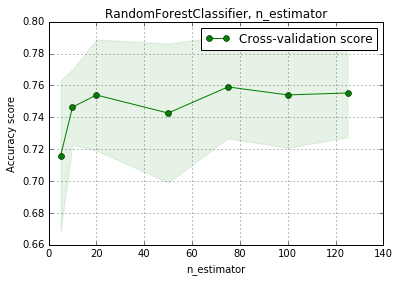

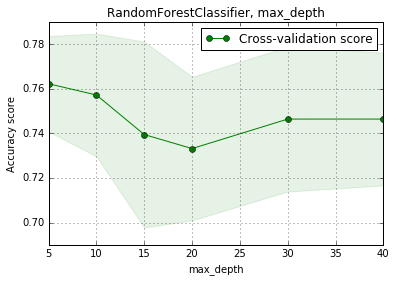

In [10]:
cross_validate_model(agg_df, y)

We compute the `feature_importance` for our model 

In [11]:
def show_features_ranking(X, y):
    clf = RandomForestClassifier(n_estimators=50,max_depth=5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf.fit(X_train, y_train)

    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %s (%f)" % (f + 1, X.columns[f], importances[indices[f]]))

In [12]:
show_features_ranking(agg_df, y)

Feature ranking:
1. club (0.271409)
2. defeats (0.114060)
3. games (0.095749)
4. goals (0.071234)
5. height (0.065073)
6. leagueCountry (0.063759)
7. redCards (0.062336)
8. ties (0.061673)
9. victories (0.058355)
10. weight (0.057145)
11. yellowCards (0.046734)
12. yellowReds (0.032473)


We compute the feature importance again after droping the less important features. We do not observe significant changes in the `feature_importance_`

In [13]:
show_features_ranking(agg_df.drop(['yellowReds','yellowCards','weight','victories'],axis=1), y)

Feature ranking:
1. club (0.225935)
2. defeats (0.138681)
3. games (0.138206)
4. goals (0.127478)
5. height (0.108802)
6. leagueCountry (0.097340)
7. redCards (0.082899)
8. ties (0.080660)


# 2) Clustering

In this section we apply the unsupervised clustering algorithm KMeans to classify the players in two clusters based on the aggregated data from the list of games. Our goal is to see if certain selection of feature will give us a high silhouette and give us two cluster that separate black and white players

In [14]:
def clustering(X):
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    
    # we set our accuracy measure the percentage of players in the correct cluster, by supposing that either 
    # cluster 0 is for black and 1 is for white or the opposite
    accuracy = max((labels == y).sum()/len(y), 1-(labels == y).sum()/len(y))
    silhouette = silhouette_score(X, labels, metric="euclidean")
    
    
    return silhouette, accuracy 

In [17]:
silhouette, accuracy = clustering(agg_df)

print("Silhouette score = %f" % silhouette)
print("Accuracy = %f" % accuracy)

Silhouette score = 0.556910
Accuracy = 0.571609


Now, let's remove one feature at a time and see the evolution of our two scores

In [18]:
agg_df.columns

Index(['club', 'defeats', 'games', 'goals', 'height', 'leagueCountry',
       'redCards', 'ties', 'victories', 'weight', 'yellowCards', 'yellowReds'],
      dtype='object')

In [19]:
def feature_removal(X):
    dic_sil = {}
    dic_acc = {}
    removed_columns = []
    
    for iteration in range(6):
        max_sil = 0
        best_col = X.columns[0]
        
        # we want to find the best column to remove which we select by trying to maximise the silhouette
        for column in X.columns:
            sil, acc = clustering(X.drop(column, axis=1))
            if sil > max_sil:
                max_sil=sil
                best_col = column
        
        X.drop(best_col, axis=1, inplace=True)
        dic_sil[best_col], dic_acc[best_col] = clustering(X)
        removed_columns.append(best_col)
        
    return dic_sil, dic_acc, removed_columns

def plot_feature_removal_evolution(dic_sil, dic_acc):
    x = np.arange(len(dic_sil))
    labels = list(dic_sil.keys())
    col_width = 0.35
    
    fig = plt.figure(figsize=(15, 4))
    plt.xlabel("Feature removed")
    plt.ylabel("Scores")
    
    ax = fig.add_subplot(111)
    ax.set_title("Scores evolution after iterative features removal")
    ax.set_xticks(x + col_width)
    x_tick_names = ax.set_xticklabels(dic_sil.keys())
    plt.setp(x_tick_names, rotation=45, fontsize=10)
    
    plt.bar(x, dic_sil.values(), col_width ,color='b', label='Silhouette score')
    plt.bar(x + col_width, dic_acc.values(), col_width, color='g', label='Accuracy score')
    
    plt.legend(loc="best")
    
    plt.show()   

In [20]:
dic_sil, dic_acc, removed_columns = feature_removal(agg_df.copy())
removed_columns

['club', 'weight', 'height', 'games', 'goals', 'victories']

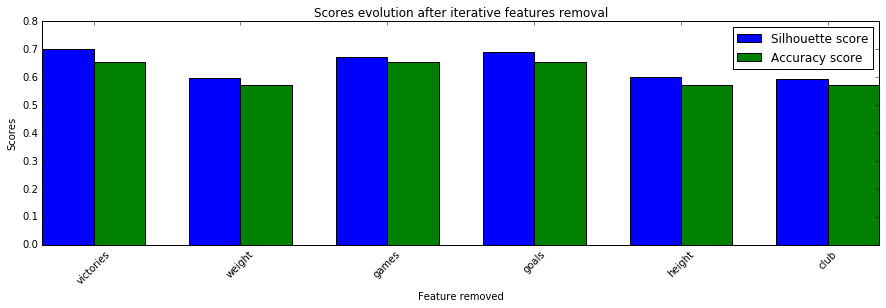

In [21]:
plot_feature_removal_evolution(dic_sil, dic_acc)

We can observe that after removing the sixth column `victories`, we have a silhouette of 0.7 and an accuracy of 0.65 which is close to what we obtain in question 1.